In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cx_Oracle as sql 
from dateutil.relativedelta import relativedelta
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import widgets, interactive


In [2]:
#DB details
ip = 'localhost'
port = 1521
SID = 'xe'
dsn_tns = sql.makedsn(ip, port, SID)
username = 'system'
password = '123'

In [3]:
#Data preparation
data = pd.read_csv("archive/indexData.csv")
info = pd.read_csv("archive/indexInfo.csv")
processed = pd.read_csv("archive/indexProcessed.csv")

In [4]:
data.Date = data.Date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
data = data.astype(object).replace(np.nan, None)
processed = processed.astype(object).replace(np.nan, None)
processed.Date = processed.Date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [5]:
#Delete 'data','info','processed' tables from DB 
def delete_tables(): 
    try:
        conn = sql.connect(username, password, dsn_tns)
        try:
            curs = conn.cursor()
            for x in ['data','info','processed']:
                try:
                    curs.execute(f'''
                            DROP TABLE system.{x}
                                   ''')
                except:
                    print('error occurred on '+x+' table')
        finally:
            curs.close()
    finally:
        if conn is not None:
            conn.close()            

In [6]:
#Delete 'V_NOTPROCESSED','V_PROCESSED' views from DB 
def delete_views(): 
    try:
        conn = sql.connect(username, password, dsn_tns)
        try:
            curs = conn.cursor()
            for x in ['V_NOTPROCESSED','V_PROCESSED']:
                try:
                    curs.execute(f'''
                            DROP VIEW {x}
                                   ''')
                except:
                    print('error occurred on '+x+' table\nTable do not exist')
        finally:
            curs.close()
    finally:
        if conn is not None:
            conn.close()   

In [7]:
 #execute sql querry/statement with automatic opening and closing connection to DB 
def execute(sqlcmd):
    try:
        conn = sql.connect(username, password, dsn_tns)
        try:
            curs = conn.cursor()
            curs.execute(sqlcmd)
        finally:
            conn.commit()
            curs.close()
    finally:
        if conn is not None:
            conn.close()

In [8]:
#execute sql querry/statement and executes it against all parameter sequences automatic opening and closing connection to DB 
def executemany(sqlcmd, seq_of_params): 
    try:
        conn = sql.connect(username, password, dsn_tns)
        try:
            curs = conn.cursor()
            curs.executemany(sqlcmd, seq_of_params)
        finally:
            conn.commit()
            curs.close()
    finally:
        if conn is not None:
            conn.close()

In [12]:
#delete_tables()
#delete_views()

In [11]:
sql_create_table = ['''
        CREATE TABLE info (
            info_region varchar(15),
            info_exchange varchar(32),
            info_index varchar(10) primary key,
            info_currency varchar(3)
            )
               ''',
                '''
        CREATE TABLE data (
            data_key int GENERATED BY DEFAULT ON NULL AS IDENTITY primary key, 
            data_index varchar(10),
            data_date date,
            data_open float,
            data_high float,
            data_low float,
            data_close float,
            data_adj_close float,
            data_volume float
    
            )
               ''',
                  
                 '''
        CREATE TABLE processed (
            pr_key int GENERATED BY DEFAULT ON NULL AS IDENTITY primary key,
            pr_index varchar(10) ,
            pr_date date,
            pr_open float,
            pr_high float,
            pr_low float,
            pr_close float,
            pr_adj_close float,
            pr_volume float,
            pr_close_USD float
            )
               '''
                 ]

In [13]:
for cmd in sql_create_table: #Create empty tables in db
    execute(cmd)

In [14]:
sql_insert_tables = {"INSERT INTO SYSTEM.INFO VALUES(:1,:2,:3,:4)" : [tuple(x) for x in info.to_numpy()],
                     "INSERT INTO SYSTEM.DATA(data_index, data_date, data_open, data_high, data_low, data_close, data_adj_close, data_volume) VALUES(:1,:2,:3,:4,:5,:6,:7,:8)": [tuple(x) for x in data.to_numpy()],
                     "INSERT INTO SYSTEM.PROCESSED(pr_index, pr_date, pr_open, pr_high, pr_low, pr_close, pr_adj_close, pr_volume, pr_close_usd) VALUES(:1,:2,:3,:4,:5,:6,:7,:8,:9)": [tuple(x) for x in processed.to_numpy()],
}

In [15]:
for cmd, values in sql_insert_tables.items(): #Insert data from csv to database
    try:
        executemany(cmd, values)
    except:
        print(cmd)

In [16]:
altedtable = ['ALTER TABLE DATA ADD CONSTRAINT FK_DATA FOREIGN KEY ("DATA_INDEX") REFERENCES "INFO" ("INFO_INDEX")',
              'ALTER TABLE PROCESSED ADD CONSTRAINT FK_PROCESSED FOREIGN KEY ("PR_INDEX") REFERENCES "INFO" ("INFO_INDEX")',
              'ALTER TABLE PROCESSED ADD CONSTRAINT FK_PROCESSED2 FOREIGN KEY ("PR_KEY") REFERENCES "DATA" ("DATA_KEY")'
             ] 

In [17]:
for cmd in altedtable: #set foreign keys
    execute(cmd)

In [18]:
processed_update_key = '''
        UPDATE (
        Select pr_key, data_key from processed
        inner join data on data.data_index = processed.pr_index
        where pr_index = data_index and pr_date = data_date
        ) t
        SET t.pr_key = t.data_key
'''

In [19]:
execute(processed_update_key) #update proccesed key on based on data key 

In [20]:
create_V_NOTPROCESSED = '''
        CREATE VIEW "V_NOTPROCESSED" AS 
            SELECT data_index as data_index, info_region AS info_region, sum(DATA_OPEN) as SUM_DATA_OPEN, sum(DATA_HIGH) as SUM_DATA_HIGH,
            sum(DATA_LOW) as SUM_DATA_LOW, sum(DATA_CLOSE) as SUM_DATA_CLOSE, sum(DATA_ADJ_CLOSE) as SUM_DATA_ADJ_CLOSE, sum(DATA_VOLUME) as SUM_DATA_VOLUME FROM data
            FULL OUTER JOIN processed on processed.pr_key = data.data_key
            LEFT JOIN info ON info.info_index = data.data_index
            WHERE PR_KEY IS NULL
            GROUP BY info_region, data_index
            ORDER BY info_region, data_index

'''

In [21]:
execute(create_V_NOTPROCESSED)

In [22]:
create_V_PROCESSED = '''
    create view "V_PROCESSED" as
    SELECT t.INFO_REGION, t.PR_YR, t.PR_MON, t.SUM_PR_OPEN, t.PR_HIGH, 
        t.SUM_PR_LOW, t.SUM_PR_CLOSE, t.SUM_PR_ADJ_CLOSE, t.SUM_PR_VOLUME, t.SUM_PR_CLOSE_USD,
        t.MAX_PR_OPEN, t.MIN_PR_LOW, info.INFO_EXCHANGE, info.INFO_CURRENCY
        FROM 
            (select info_region, extract(year from pr_date) as pr_yr, extract(month from pr_date) as pr_mon,
            sum(PR_OPEN) as sum_PR_OPEN, sum(PR_HIGH) as PR_HIGH, sum(PR_LOW) as sum_PR_LOW, sum(PR_CLOSE) as sum_PR_CLOSE, sum(PR_ADJ_CLOSE) as sum_PR_ADJ_CLOSE, sum(PR_VOLUME) as sum_PR_VOLUME,
            sum(PR_CLOSE_USD) as sum_PR_CLOSE_USD, max(PR_OPEN) as max_PR_OPEN, min(PR_LOW) as min_PR_LOW
            FROM processed
            left join info on info.info_index = processed.pr_index
            group by info_region, extract(year from pr_date), extract(month from pr_date)
            order by info_region, pr_yr, pr_mon) t
            
        LEFT JOIN info ON t.info_region = info.info_region
'''

In [23]:
execute(create_V_PROCESSED)

Visualization

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import widgets, interactive

In [25]:
def import_view_db():
    try:
        connection = sql.connect(username, password, dsn_tns)

        return pd.read_sql(f'select * from V_PROCESSED', con=connection), pd.read_sql(f'select * from V_NOTPROCESSED', con=connection)
    finally:
        if connection is not None:
            connection.close()

In [26]:
V_PROCESSED, V_NOTPROCESSED = import_view_db()

In [27]:
country = widgets.Dropdown(
    options=list(V_PROCESSED['INFO_REGION'].unique()),
    value='United States',
    description='Country:')

In [30]:
def graphmaxopen(country):
    V_PROCESSED, V_NOTPROCESSED = import_view_db()
    mean_max_open = V_PROCESSED.query(f"INFO_REGION == '{country}'" ).groupby(['PR_MON', 'INFO_CURRENCY']).mean()
    mean_max_open['Date']=[f"2021-{x}-1" for x in mean_max_open.reset_index().PR_MON.to_list()]
    mean_max_open['Date'] = pd.to_datetime(mean_max_open.Date)
    mean_max_open = mean_max_open.reset_index().set_index('Date')

    fig, ax = plt.subplots(2, figsize=(20, 15))
    ax[0].plot(mean_max_open.MAX_PR_OPEN, '--o', alpha=0.5)
    ax[0].bar(mean_max_open.MAX_PR_OPEN.index, mean_max_open.MAX_PR_OPEN,
          width=20)
    locator = mdates.MonthLocator()  # every month
    fmt = mdates.DateFormatter('%b')
    ax[0].xaxis.set_major_locator(locator)
    ax[0].xaxis.set_major_formatter(fmt)

    ax[0].axes.set_ylim((mean_max_open.MAX_PR_OPEN.min()-200, mean_max_open.MAX_PR_OPEN.max()+200))
    
    ax[0].set_title('Highest price (mean) at the moment of the opening date')
    ax[0].set_xlabel('months')     
    ax[0].yaxis.set_label_text(mean_max_open.INFO_CURRENCY[0])

    ax[0].bar_label(ax[0].containers[0], padding=5)
    
    
    ax[1].plot(mean_max_open.MIN_PR_LOW, '--o', alpha=0.5, color='orange')
    ax[1].bar(mean_max_open.MIN_PR_LOW.index, mean_max_open.MIN_PR_LOW,
          width=20, color='orange')
    locator = mdates.MonthLocator()  # every month
    fmt = mdates.DateFormatter('%b')
    ax[1].xaxis.set_major_locator(locator)
    ax[1].xaxis.set_major_formatter(fmt)

    ax[1].set_title('Minimum price (mean)')
    ax[1].axes.set_ylim((mean_max_open.MIN_PR_LOW.min()-200, mean_max_open.MIN_PR_LOW.max()+200))
    ax[1].set_xlabel('months')     
    ax[1].yaxis.set_label_text(mean_max_open.INFO_CURRENCY[0])
    ax[1].bar_label(ax[1].containers[0], padding=5)
    plt.show()
    

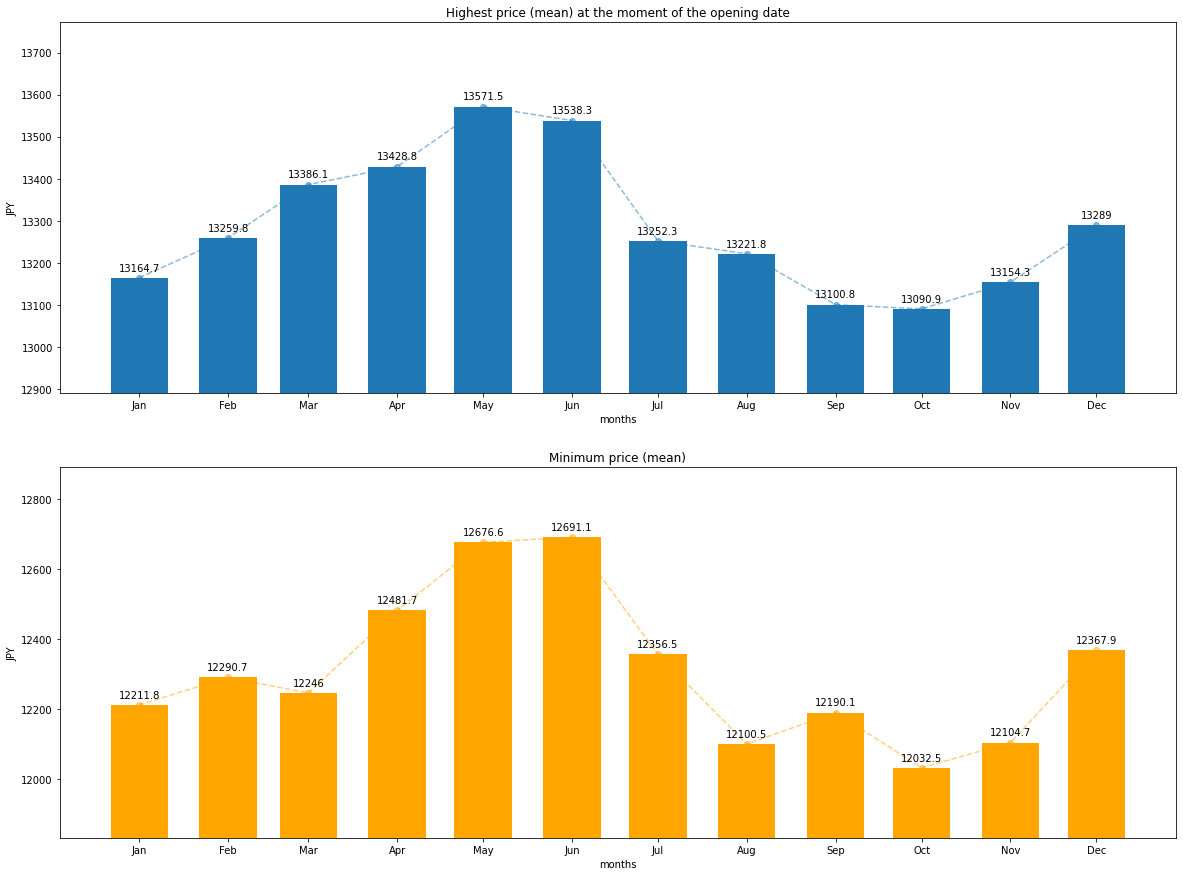

In [31]:
#visualization 
graphmaxopen("Japan")

In [29]:
#visualization with ComboBox
interactive(graphmaxopen, country=country)

interactive(children=(Dropdown(description='Country:', index=10, options=('Canada', 'China', 'Europe', 'German…